# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.

## General Rules

Please check all the requirements listed on Canvas, but here are some general rules:

- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name: Liviu-Daniel Florescu**  
**Neptun ID: F06DLV**

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines

Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.


# 0. Necessary Imports

Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**


In [1]:
# ADD YOUR CODE HERE
import torch
import torchvision.transforms.v2 as transforms
import torch.nn as nn

import torchtext
from torch.utils.data import Dataset, DataLoader

# 1. DATASET

For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.


### 1.1. Download dataset

The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235


### 1.2. Load dataset

In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.


In [2]:
from collections import Counter, OrderedDict
import csv
import os
from typing import List
from torch.utils.data import random_split

from matplotlib import pyplot as plt

IMAGES_DIR = "dataset/Images"
CAPTIONS_FILE_PATH = "dataset/captions.txt"

PAD = "<pad>"
UNK = "<unk>"
SOS = "<sos>"
EOS = "<eos>"
VOCAB_SPECIALS = [PAD, UNK, SOS, EOS]


def read_captions(captions_path) -> dict:
    img_name_to_captions = dict()

    with open(captions_path, "r") as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        for row in reader:
            img_name, caption = row
            caption = caption.lower()

            img_name_to_captions.setdefault(img_name, [])
            img_name_to_captions[img_name].append(caption)

    return img_name_to_captions


def create_vocabulary(captions, min_freq) -> torchtext.vocab.Vocab:
    raw_tokens = [t for caption in captions for t in caption.split(" ")]
    print("Raw token count:", len(raw_tokens))

    counter = Counter(raw_tokens)
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    vocab = torchtext.vocab.vocab(
        OrderedDict(sorted_by_freq_tuples), min_freq=min_freq, specials=VOCAB_SPECIALS
    )
    vocab.set_default_index(vocab[UNK])

    print(f"Created vocabulary with {len(vocab.get_itos())} tokens.")

    return vocab


def tokenize_captions(vocab, captions):
    def tokenize_caption(caption):
        tokens = [vocab[token] for token in caption.split(" ")]
        return [vocab[SOS]] + tokens + [vocab[EOS]]

    return [tokenize_caption(caption) for caption in captions]


def filter_img_caption_dict(img_caption_dict, wanted_images):
    return {img: list(img_caption_dict[img]) for img in wanted_images}


img_name_to_captions = read_captions(CAPTIONS_FILE_PATH)
all_captions = [
    caption
    for img_captions in img_name_to_captions.values()
    for caption in img_captions
]
all_images = list(img_name_to_captions.keys())
VOCAB = create_vocabulary(all_captions, min_freq=5)

for img, caps in img_name_to_captions.items():
    img_name_to_captions[img] = tokenize_captions(VOCAB, caps)


# Fix generator for reproducible results
img_splits = random_split(all_images, [0.6, 0.2, 0.2], torch.Generator().manual_seed(0))
_train_data = filter_img_caption_dict(img_name_to_captions, img_splits[0])
_val_data = filter_img_caption_dict(img_name_to_captions, img_splits[1])
_test_data = filter_img_caption_dict(img_name_to_captions, img_splits[2])

Raw token count: 476665
Created vocabulary with 3005 tokens.


Split your dataset into train, val and test sets


In [3]:
import random


class FlickrSubset(Dataset):
    def __init__(self, data: dict, vocab, img_dir, transform=None, split="train"):
        self.data = data
        self.img_names = list(self.data.keys())
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform
        self.split = split

        print(f"Created {self.split} dataset with {len(self)} elements.")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        all_captions = self.data[img_name]
        caption = random.sample(all_captions, k=1)[0]

        img_path = os.path.join(self.img_dir, img_name)
        image = plt.imread(img_path)
        if self.transform:
            image = self.transform(image)

        return (image, torch.tensor(caption, dtype=torch.int32), all_captions)


IMG_SIZE = (224, 224)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

common_transforms = [
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(NORM_MEAN, NORM_STD),
]
train_transforms = list(common_transforms)
train_transforms.insert(
    2, transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)
)

train_transform = transforms.Compose(train_transforms)
val_test_transform = transforms.Compose(common_transforms)


train_dataset = FlickrSubset(
    _train_data, VOCAB, IMAGES_DIR, train_transform, split="train"
)
val_dataset = FlickrSubset(
    _val_data, VOCAB, IMAGES_DIR, val_test_transform, split="val"
)
test_dataset = FlickrSubset(
    _test_data, VOCAB, IMAGES_DIR, val_test_transform, split="test"
)

Created train dataset with 4855 elements.
Created val dataset with 1618 elements.
Created test dataset with 1618 elements.


/mnt/128EB2C18EB29CA3/uni/master/ifros/year2/sem1/deep_networks/labs/venv/lib/python3.11/site-packages/torchvision/transforms/v2/functional/_type_conversion.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  output = torch.from_numpy(inpt).permute((2, 0, 1)).contiguous()


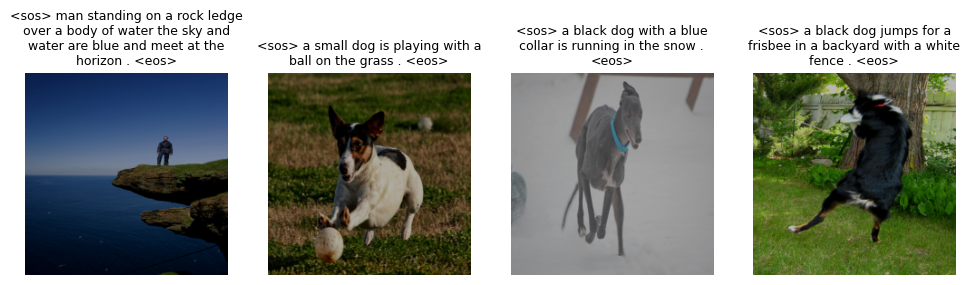

In [4]:
import random

import numpy as np

from textwrap import wrap

random.seed(0)


def denormalize(tensor, mean=NORM_MEAN, std=NORM_STD):
    """
    Denormalizes a tensor normalized by transforms.Normalize.

    Args:
        tensor (torch.Tensor): Normalized tensor.
        mean (list or tuple): Mean values used for normalization (one for each channel).
        std (list or tuple): Std values used for normalization (one for each channel).

    Returns:
        torch.Tensor: Denormalized tensor.
    """
    # Check if mean and std are single values, in case of grayscale images
    if not isinstance(mean, (list, tuple)):
        mean = [mean]
    if not isinstance(std, (list, tuple)):
        std = [std]

    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)

    return tensor * std + mean


def decode_caption(caption: torch.Tensor, vocab: torchtext.vocab.Vocab):
    words = [vocab.get_itos()[token] for token in caption.tolist()]
    return " ".join(words)


def visualize_dataset(ds: Dataset, wanted_images=4):
    f, axs = plt.subplots(1, wanted_images)
    f.set_figwidth(3 * wanted_images)
    sample_ids = random.sample(list(range(len(ds))), k=wanted_images)
    for i, sample_id in enumerate(sample_ids):
        image_tensor, caption, _ = ds[sample_id]
        image = denormalize(image_tensor).numpy()
        image = np.transpose(image, (1, 2, 0))
        image[image > 1] = 1
        text = decode_caption(caption, ds.vocab)
        wrapped_text = "\n".join(wrap(text, width=35))

        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(wrapped_text, fontsize=9)


visualize_dataset(train_dataset)

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.


In [5]:
def pad_caption(caption: torch.Tensor, target_length):
    padding_tensor = torch.tensor([VOCAB[PAD]] * (target_length - len(caption)))
    return torch.concat([caption, padding_tensor], dim=0)


def pad_caption_batch(captions):
    max_caption_length = max(map(len, captions))
    padded_captions = [pad_caption(c, max_caption_length) for c in captions]
    return torch.stack(padded_captions).int()


def collate_fn(batch):
    """Custom collation function to pad captions in a single batch so that they have the same length."""

    images = torch.stack([pair[0] for pair in batch])
    raw_captions = [pair[1] for pair in batch]
    all_captions = [pair[2] for pair in batch]

    return (images, pad_caption_batch(raw_captions), all_captions)


common_dataloader_kwargs = {
    "batch_size": 16,
    "num_workers": 4,
    "pin_memory": True,
    "collate_fn": collate_fn,
}


train_loader = DataLoader(train_dataset, shuffle=True, **common_dataloader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **common_dataloader_kwargs)
test_loader = DataLoader(test_dataset, shuffle=False, **common_dataloader_kwargs)

# 2. MODEL

For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.


In [6]:
# Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:

- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:

- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.


#### Reference

Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [7]:
from torchvision import models
import torch.nn.functional as F

# Inspired by
# https://github.com/mnmjh1215/show-attend-and-tell-pytorch/blob/master/model.py
# https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/models.py

ENC_IMAGE_SIZE = (14, 14)


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

        wanted_layers = list(resnet.children())[:-2]
        self.backbone = nn.Sequential(*wanted_layers)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(ENC_IMAGE_SIZE)

        mock_input = torch.randn(1, 3, *IMG_SIZE)
        with torch.no_grad():
            mock_output = self.forward(mock_input)
            # save the feature dimension
            self.dim = mock_output.shape[-1]

    def forward(self, images):
        x = self.backbone(images)

        # print("BACKBONE OUTPUT:", x.shape)

        # adaptive pooling to obtain features of desired size
        x = self.adaptive_pool(x)

        # print("adap output:", x.shape)

        x = x.permute(0, 2, 3, 1)  # place encoding dimension at the end

        batch_size, _, _, enc_dim = x.shape

        # flatten along the feature count dimensions (image shape)
        x = x.view(batch_size, -1, enc_dim)

        return x


class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):  # generous hint
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)

        # keep one value (score) for each feature
        self.attention = nn.Linear(attention_dim, 1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden_state):
        encoder_att = self.encoder_att(features)  # (batch, features, att)
        decoder_att = self.decoder_att(hidden_state).unsqueeze(1)  # (batch, 1, att)

        summed_att = encoder_att + decoder_att

        attention = self.attention(self.tanh(summed_att))  # (batch, features, 1)

        # dim 2 is 1, so it can be removed
        attention = attention.squeeze(2)  # (batch, features)

        # compute softmax scores
        weights = self.softmax(attention)  # (batch, features)

        # perform weighted sum on full-dimension features
        # (batch, encoder dim)
        context = (features * weights.unsqueeze(2)).sum(dim=1)

        return context, weights


class Decoder(nn.Module):
    def __init__(
        self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, dropout
    ):
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.emb = nn.Embedding(vocab_size, embed_size)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)

        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

    def train(self, mode=True):
        super().train(mode)
        self.attention.train(mode)

    def init_hidden_state(self, features):
        """Initialise hidden and cell states for LSTM."""
        mean_features = features.mean(dim=1)

        h = self.init_h(mean_features)
        c = self.init_c(mean_features)
        return h, c

    def forward_with_teacher_forcing(
        self, features: torch.Tensor, captions: torch.Tensor, tf_probability: float
    ):
        """
        Forward propagation in Teacher-forcing mode using:
        - `features` (batch, features, dimensions) extracted by the encoder
        - `captions` (batch, caption length) ground truth
        """

        batch_size, feature_count, feature_dim = features.shape

        h, c = self.init_hidden_state(features)

        embeddings = self.emb(captions)  # (batch, caption length, embedding)

        target_length = captions.shape[1] - 1  # do not predict start

        # For each image, for each slot, a probability for each word in the vocab
        predictions = torch.zeros(batch_size, target_length, self.vocab_size).to(device)

        # For each image, for each slot, a weight for each feature in the encoding
        alphas = torch.zeros(batch_size, target_length, feature_count).to(device)

        # Captions predicted so far
        pred_caps = torch.full((batch_size, 1), VOCAB[SOS]).int().to(device)

        tf_or_not = []

        # For each slot
        for t in range(target_length):
            context, weights = self.attention(features, h)

            if np.random.random() < tf_probability:
                # Use ground truth previous word
                emb = embeddings[:, t, :]
                tf_or_not.append(1)
            else:
                # Use predicted previous word
                emb = self.emb(pred_caps.clone())[:, -1, :]
                tf_or_not.append(0)

            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat([emb, gated_context], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds

            alphas[:, t, :] = weights

            pred_caps = torch.cat(
                [
                    pred_caps,
                    torch.argmax(preds, dim=1).unsqueeze(1),  # save best word
                ],
                dim=1,
            )

            # print(pred_caps)

        pred_caps = torch.argmax(predictions, dim=2).to(device)
        # print(tf_or_not)

        return predictions, pred_caps, alphas

    def forward_greedy(self, features: torch.Tensor, max_length):
        """Forward propagation in greedy mode, for a batch."""

        batch_size, feature_count, feature_dim = features.shape

        target_length = max_length - 1

        h, c = self.init_hidden_state(features)

        # For each image, for each slot, a probability for each word in the vocab
        predictions = torch.zeros(batch_size, target_length, self.vocab_size).to(device)

        # For each image, for each slot, a weight for each feature in the encoding
        alphas = torch.zeros(batch_size, target_length, feature_count).to(device)

        # Captions predicted so far
        captions = torch.full((batch_size, target_length), VOCAB[SOS]).int().to(device)

        # For each slot
        for t in range(target_length):
            context, weights = self.attention(features, h)

            prev_word_embedding = self.emb(captions.clone())[:, t, :]

            lstm_input = torch.cat([prev_word_embedding, context], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            # predict without dropout
            preds = self.fc(h)  # (batch_size, vocab_size)
            predictions[:, t, :] = preds

            captions[:, t] = torch.argmax(preds, dim=1)  # save highest-scoring word

            alphas[:, t, :] = weights

        return predictions, captions, alphas

    def __forward_beam_search(self, img_features: torch.Tensor, beam_size, max_length):
        k = beam_size

        img_features: torch.Tensor
        feature_count, feature_dim = img_features.shape

        beam_features = img_features.view(1, feature_count, feature_dim)
        beam_features = beam_features.expand(k, feature_count, feature_dim)

        preds = torch.zeros(k, 1, self.vocab_size).to(device)
        preds[:, 0, VOCAB[SOS]] = 1

        k_prev_words = torch.full((k, 1), fill_value=VOCAB[SOS]).long().to(device)

        seqs = k_prev_words
        top_k_scores = torch.zeros(k, 1).to(device)

        complete_seqs = []
        complete_seqs_scores = []
        complete_seqs_preds = []

        step = 1
        h, c = self.init_hidden_state(beam_features)

        while step < max_length:
            embeddings = self.emb(k_prev_words).squeeze(1)

            context, _ = self.attention(beam_features, h)

            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat([embeddings, gated_context], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            # raw scores = word scores corresponding to k parallel predictions
            # NO DROPOUT
            raw_scores = self.fc(h)

            sm_scores = F.softmax(raw_scores, dim=1)

            # combine score so far with current scores
            scores = top_k_scores.expand_as(sm_scores) + sm_scores  # (k, vocab size)

            # top_k_scores = the score of the k best words
            # top_k_words = the index of k the best words

            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, dim=0)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, dim=0)

            prev_seq_idxs = top_k_words // self.vocab_size
            next_word_idxs = top_k_words.remainder(self.vocab_size)

            seqs = torch.cat(
                [
                    seqs[prev_seq_idxs],  # previous best sequence
                    next_word_idxs.unsqueeze(1),  # current best word (as list)
                ],
                dim=1,
            )

            preds = torch.cat(
                [
                    preds[prev_seq_idxs],
                    raw_scores[prev_seq_idxs].unsqueeze(1),
                ],
                dim=1,
            )

            # PREDS argmax will not match the word selected in the caption
            # because we are keeping the top k words (but only one has max value)
            # Still: it makes sense to use that for the loss
            # because the highest-scoring word should be correct

            # print(prev_seq_idxs)
            # print("seqs\n", seqs)
            # print("preds argmax\n", torch.argmax(preds, 2))

            incomplete_idxs = [
                i
                for i, word_idx in enumerate(next_word_idxs.tolist())
                if word_idx != VOCAB[EOS]
            ]

            complete_idxs = list(set(range(len(next_word_idxs))) - set(incomplete_idxs))

            if complete_idxs:
                # Save complete sequences
                complete_seqs.extend(seqs[complete_idxs].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_idxs])
                complete_seqs_preds.extend(preds[complete_idxs].tolist())

            # Reduce beam size
            k -= len(complete_idxs)

            if k == 0:
                break

            # Remove data corresponding to complete sequences
            seqs = seqs[incomplete_idxs]
            preds = preds[incomplete_idxs]

            incomplete_prev_word_idxs = prev_seq_idxs[incomplete_idxs]

            h = h[incomplete_prev_word_idxs]
            c = c[incomplete_prev_word_idxs]

            beam_features = beam_features[incomplete_prev_word_idxs]

            top_k_scores = top_k_scores[incomplete_idxs].unsqueeze(1)
            k_prev_words = next_word_idxs[incomplete_idxs].unsqueeze(1)

            step += 1

        if complete_seqs_scores:
            # At least one complete sequence
            best_seq_idx = complete_seqs_scores.index(max(complete_seqs_scores))

            # Prepare the caption
            raw_caption = complete_seqs[best_seq_idx]
            seq_length = len(raw_caption)
            padding = [VOCAB[PAD]] * (max_length - seq_length)
            caption = torch.IntTensor(raw_caption + padding)

            # Prepare the predictions vector
            pred = torch.zeros(max_length, self.vocab_size)
            pred[:seq_length] = torch.FloatTensor(complete_seqs_preds[best_seq_idx])
            # TODO save alphas
        else:
            # Get sequence with highest score
            best_seq_idx = torch.argmax(top_k_scores.squeeze())
            caption = seqs[best_seq_idx]
            pred = preds[best_seq_idx]

        return pred, caption, None

    def forward_beam_search(self, features: torch.Tensor, beam_size, max_length):
        batch_size = features.size(0)

        length = max_length - 1  # without <sos>

        batch_predictions = torch.zeros(batch_size, length, self.vocab_size).to(device)
        batch_captions = torch.zeros(batch_size, length).int().to(device)
        batch_alphas = []

        for i, img_features in enumerate(features):
            preds, caption, alphas = self.__forward_beam_search(
                img_features, beam_size, max_length
            )

            # preds and captions have <sos>
            batch_predictions[i, :, :] = preds[1:]
            batch_captions[i, :] = caption[1:]

        return batch_predictions, batch_captions, batch_alphas

Combine the encoder - attention - decoder


In [8]:
import shutil
import time
from tqdm import tqdm

WEIGHTS_ROOT_PATH = "weights"
os.makedirs(WEIGHTS_ROOT_PATH, exist_ok=True)

PLOTS_ROOT_PATH = "plots"


class ImageCaptioningModel(nn.Module):
    init_param_names = [
        "emb_size",
        "vocab_size",
        "att_dim",
        "decoder_dim",
        "dropout",
        "id",
        "trained_epochs",
    ]

    def __init__(
        self,
        emb_size,
        vocab_size,
        att_dim,
        decoder_dim,
        dropout,
        id: str = None,
        trained_epochs: int = 0,
    ):
        super(ImageCaptioningModel, self).__init__()

        self.emb_size = emb_size
        self.vocab_size = vocab_size
        self.att_dim = att_dim
        self.decoder_dim = decoder_dim
        self.dropout = dropout
        self.id = id if id is not None else str(int(time.time()))
        self.trained_epochs = trained_epochs

        self.folder = os.path.join(WEIGHTS_ROOT_PATH, self.id)

        self.encoder = Encoder()
        self.encoder_dim = self.encoder.dim

        self.decoder = Decoder(
            emb_size, vocab_size, att_dim, self.encoder_dim, decoder_dim, dropout
        )

        print(
            f"Initialised model with ID {self.id}, previously trained for {self.trained_epochs} epochs."
        )

    def record_epoch(self):
        self.trained_epochs += 1

    def get_state(self):
        param_dict = {
            p: getattr(self, p) for p in ImageCaptioningModel.init_param_names
        }
        return {
            **param_dict,
            "state_dict": self.state_dict(),
        }

    @classmethod
    def init_from_file(cls, path: str):
        state = torch.load(path)
        kwargs = {p: state[p] for p in cls.init_param_names}
        m = ImageCaptioningModel(**kwargs)
        m.load_state_dict(state["state_dict"])
        return m

    def save_checkpoint(self, delete_prev=False):
        if delete_prev and os.path.exists(self.folder):
            shutil.rmtree(self.folder)

        os.makedirs(self.folder, exist_ok=True)

        path = os.path.join(self.folder, f"{self.trained_epochs:>03}.pt")
        state = self.get_state()
        torch.save(state, path)

        print(f"Saved model weights to {path}")

    def train(self, mode=True):
        self.encoder.train(mode)
        self.decoder.train(mode)

    def forward(
        self, images, captions=None, max_length=40, beam_size=5, tf_probability=1
    ):
        """Perform a forward pass on the given images and captions. If captions are provided, teacher forcing happens."""
        features = self.encoder(images)

        if captions is not None:
            return self.decoder.forward_with_teacher_forcing(
                features, captions, tf_probability
            )

        # return self.decoder.forward_greedy(features, max_length=max_length)
        return self.decoder.forward_beam_search(
            features, beam_size=beam_size, max_length=max_length
        )

### 2.2. Training custom model


### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation


Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.


Initialised model with ID 1731412974, previously trained for 0 epochs.

=========== Epoch 1/200 ===========
=== 0 epochs since loss decreased ===
=== 0 epochs since metric improved ===
LR not computed yet.
TF prob: 100.00%


Train: 100%|██████████| 304/304 [05:41<00:00,  1.12s/it]


Loss 4.2745 bleu1 0.4683 bleu2 0.2613 bleu3 0.0994 


Val: 100%|██████████| 102/102 [01:17<00:00,  1.31it/s]


Loss 3.6959 bleu1 0.5273 bleu2 0.3287 bleu3 0.1607 
Saved model weights to weights/1731412974/001.pt
Saved model weights to weights/1731412974/001.pt

=========== Epoch 2/200 ===========
=== 0 epochs since loss decreased ===
=== 0 epochs since metric improved ===
LR: 0.0005
TF prob: 100.00%


Train: 100%|██████████| 304/304 [05:25<00:00,  1.07s/it]


Loss 3.5276 bleu1 0.5550 bleu2 0.3393 bleu3 0.1676 


Val: 100%|██████████| 102/102 [01:15<00:00,  1.36it/s]


Loss 3.3947 bleu1 0.5486 bleu2 0.3455 bleu3 0.1814 
Saved model weights to weights/1731412974/002.pt
Saved model weights to weights/1731412974/002.pt

=========== Epoch 3/200 ===========
=== 0 epochs since loss decreased ===
=== 0 epochs since metric improved ===
LR: 0.0005
TF prob: 100.00%


Train: 100%|██████████| 304/304 [05:15<00:00,  1.04s/it]


Loss 3.2856 bleu1 0.5682 bleu2 0.3566 bleu3 0.1875 


Val: 100%|██████████| 102/102 [01:12<00:00,  1.40it/s]


Loss 3.2176 bleu1 0.5746 bleu2 0.3728 bleu3 0.2078 
Saved model weights to weights/1731412974/003.pt
Saved model weights to weights/1731412974/003.pt

=========== Epoch 4/200 ===========
=== 0 epochs since loss decreased ===
=== 0 epochs since metric improved ===
LR: 0.0005
TF prob: 100.00%


Train: 100%|██████████| 304/304 [05:24<00:00,  1.07s/it]


Loss 3.1189 bleu1 0.5848 bleu2 0.3737 bleu3 0.2064 


Val: 100%|██████████| 102/102 [01:10<00:00,  1.45it/s]


Loss 3.1300 bleu1 0.5796 bleu2 0.3772 bleu3 0.2163 
Saved model weights to weights/1731412974/004.pt

=========== Epoch 5/200 ===========
=== 0 epochs since loss decreased ===
=== 1 epochs since metric improved ===
LR: 0.0005
TF prob: 100.00%


Train: 100%|██████████| 304/304 [05:25<00:00,  1.07s/it]


Loss 2.9871 bleu1 0.5918 bleu2 0.3820 bleu3 0.2175 


Val: 100%|██████████| 102/102 [01:14<00:00,  1.37it/s]


Loss 3.0305 bleu1 0.6094 bleu2 0.3986 bleu3 0.2318 
Saved model weights to weights/1731412974/005.pt
Saved model weights to weights/1731412974/005.pt

=========== Epoch 6/200 ===========
=== 0 epochs since loss decreased ===
=== 0 epochs since metric improved ===
LR: 0.0005
TF prob: 90.00%


Train: 100%|██████████| 304/304 [05:29<00:00,  1.08s/it]


Loss 3.1038 bleu1 0.6190 bleu2 0.4073 bleu3 0.2334 


Val: 100%|██████████| 102/102 [01:14<00:00,  1.36it/s]


Loss 2.9798 bleu1 0.5945 bleu2 0.3926 bleu3 0.2289 
Saved model weights to weights/1731412974/006.pt

=========== Epoch 7/200 ===========
=== 0 epochs since loss decreased ===
=== 1 epochs since metric improved ===
LR: 0.0005
TF prob: 90.00%


Train: 100%|██████████| 304/304 [05:22<00:00,  1.06s/it]


Loss 2.9925 bleu1 0.6325 bleu2 0.4237 bleu3 0.2492 


Val: 100%|██████████| 102/102 [01:13<00:00,  1.38it/s]


Loss 2.9649 bleu1 0.5908 bleu2 0.3932 bleu3 0.2311 

=========== Epoch 8/200 ===========
=== 1 epochs since loss decreased ===
=== 2 epochs since metric improved ===
LR: 0.0005
TF prob: 90.00%


Train: 100%|██████████| 304/304 [05:30<00:00,  1.09s/it]


Loss 2.9410 bleu1 0.6405 bleu2 0.4313 bleu3 0.2557 


Val: 100%|██████████| 102/102 [01:09<00:00,  1.46it/s]


Loss 2.9315 bleu1 0.6072 bleu2 0.4034 bleu3 0.2410 
Saved model weights to weights/1731412974/008.pt

=========== Epoch 9/200 ===========
=== 0 epochs since loss decreased ===
=== 3 epochs since metric improved ===
LR: 5e-05
TF prob: 90.00%


Train: 100%|██████████| 304/304 [05:05<00:00,  1.01s/it]


Loss 2.7798 bleu1 0.6517 bleu2 0.4493 bleu3 0.2753 


Val: 100%|██████████| 102/102 [01:09<00:00,  1.46it/s]


Loss 2.8587 bleu1 0.6059 bleu2 0.4093 bleu3 0.2502 
Saved model weights to weights/1731412974/009.pt

=========== Epoch 10/200 ===========
=== 0 epochs since loss decreased ===
=== 4 epochs since metric improved ===
LR: 5e-05
TF prob: 90.00%


Train: 100%|██████████| 304/304 [05:13<00:00,  1.03s/it]


Loss 2.7587 bleu1 0.6571 bleu2 0.4591 bleu3 0.2856 


Val: 100%|██████████| 102/102 [01:11<00:00,  1.43it/s]


Loss 2.8624 bleu1 0.6124 bleu2 0.4143 bleu3 0.2519 

=========== Epoch 11/200 ===========
=== 1 epochs since loss decreased ===
=== 5 epochs since metric improved ===
LR: 5e-05
TF prob: 81.00%


Train: 100%|██████████| 304/304 [05:17<00:00,  1.05s/it]


Loss 2.9020 bleu1 0.6752 bleu2 0.4764 bleu3 0.2987 


Val: 100%|██████████| 102/102 [01:10<00:00,  1.44it/s]


Loss 2.8552 bleu1 0.6071 bleu2 0.4116 bleu3 0.2513 

=========== Epoch 12/200 ===========
=== 2 epochs since loss decreased ===
=== 6 epochs since metric improved ===
LR: 5e-05
TF prob: 81.00%


Train: 100%|██████████| 304/304 [05:03<00:00,  1.00it/s]


Loss 2.8836 bleu1 0.6774 bleu2 0.4790 bleu3 0.3009 


Val: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]


Loss 2.8573 bleu1 0.6134 bleu2 0.4138 bleu3 0.2496 

=========== Epoch 13/200 ===========
=== 3 epochs since loss decreased ===
=== 7 epochs since metric improved ===
LR: 5e-05
TF prob: 81.00%


Train: 100%|██████████| 304/304 [05:01<00:00,  1.01it/s]


Loss 2.8496 bleu1 0.6900 bleu2 0.4932 bleu3 0.3136 


Val: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]


Loss 2.8478 bleu1 0.6133 bleu2 0.4146 bleu3 0.2517 

=========== Epoch 14/200 ===========
=== 4 epochs since loss decreased ===
=== 8 epochs since metric improved ===
LR: 5e-05
TF prob: 81.00%


Train: 100%|██████████| 304/304 [05:03<00:00,  1.00it/s]


Loss 2.8039 bleu1 0.6839 bleu2 0.4878 bleu3 0.3091 


Val: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]


Loss 2.8373 bleu1 0.6137 bleu2 0.4132 bleu3 0.2513 

=========== Epoch 15/200 ===========
=== 5 epochs since loss decreased ===
=== 9 epochs since metric improved ===
LR: 5e-05
TF prob: 81.00%


Train: 100%|██████████| 304/304 [05:08<00:00,  1.01s/it]


Loss 2.8169 bleu1 0.6913 bleu2 0.4963 bleu3 0.3172 


Val: 100%|██████████| 102/102 [01:13<00:00,  1.39it/s]


Loss 2.8351 bleu1 0.6134 bleu2 0.4183 bleu3 0.2560 
Early stop.
Average epoch duration: 389.88s


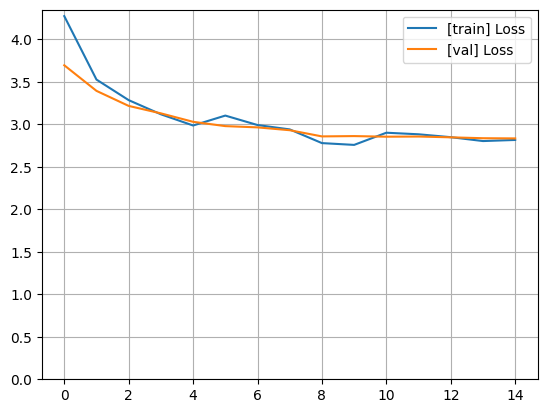

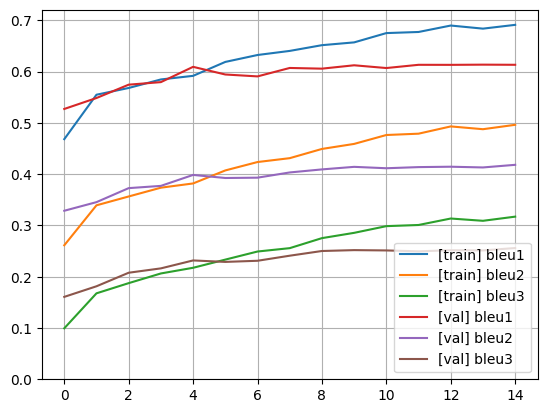

In [9]:
import torch.optim as optim
from torch import Tensor


class MetricHistory:
    def __init__(self, name="loss", split="train"):
        self.name = name
        self.split = split
        assert split in ["train", "val", "test"]
        self.history: List[float] = []
        self.current_value = 0
        self.batch_count = 0

    @property
    def full_name(self):
        return f"[{self.split}] {self.name}"

    def record_batch_value(self, tensor: Tensor):
        """Record the value for a single batch."""

        self.current_value += tensor.item()
        self.batch_count += 1

    def end_epoch(self, with_print: bool = True):
        """
        Finalize an epoch, i.e. compute and store the value for that epoch.
        """
        value = self.current_value / self.batch_count
        self.history.append(value)
        self.current_value = 0
        self.batch_count = 0

        if with_print:
            print(f"{self.name} {value:.4f}", end=" ")

    def get_last_value(self) -> float:
        """Return the last value stored in the history."""
        return self.history[-1]


class StepScheduler:
    """Scheduler for an exponential value."""

    def __init__(self, initial_value: float, gamma: float, step_size: int):
        self.v = initial_value
        self.gamma = gamma
        self.step_size = step_size
        self.current_step = 0

    def get_value(self):
        """Returns the current value stored in the scheduler."""
        return self.v

    def step(self):
        """Multiply the current value by gamma, every k steps"""
        self.current_step += 1
        if self.current_step == self.step_size:
            self.v *= self.gamma
            self.current_step = 0


def plot_histories(
    histories: List[MetricHistory], filename: str, folder: str = PLOTS_ROOT_PATH
):
    os.makedirs(folder, exist_ok=True)
    for h in histories:
        data = np.array(h.history)
        plt.plot(range(len(data)), data, label=h.full_name)

    plt.ylim(bottom=0)
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(folder, filename), dpi=200, bbox_inches="tight")
    plt.show()


def non_pad_length(padded_caption):
    i = len(padded_caption) - 1
    while padded_caption[i] == 0:
        i -= 1

    return i + 1


def bleu(hyp, ref, n):
    return torch.tensor(torchtext.data.metrics.bleu_score(hyp, ref, n, [1 / n] * n))


def int_caption_to_str(caption):
    return list(map(lambda x: VOCAB.get_itos()[x], caption))


def forward_batch(
    model: ImageCaptioningModel,
    images: Tensor,
    captions: Tensor,  # (batch size, length)
    all_captions,
    loss_fn,
    teacher_forcing_p: float = 0,
):

    preds: Tensor  # (batch size, length, vocab size)

    captions_input = None  # Default: do not provide captions
    max_length = captions.shape[-1]  # maybe don't limit length like this

    if teacher_forcing_p > 0:
        # Perform teacher forcing
        captions_input = captions

    preds, pred_captions, att_weights = model.forward(
        images,
        captions=captions_input,
        max_length=max_length,
        tf_probability=teacher_forcing_p,
    )
    vocab_size = preds.shape[-1]

    preds_reshaped = preds.reshape(-1, vocab_size).float()

    captions = captions[:, 1:]  # skip start

    captions_reshaped = captions.reshape(-1).long()

    cross_entropy_loss = loss_fn(preds_reshaped, captions_reshaped)
    # att_loss = 0  # ((1 - att_weights.sum(1)) ** 2).mean()
    # loss = cross_entropy_loss + att_loss

    hypotheses = []
    for pred_caption in pred_captions:
        caption = int_caption_to_str(pred_caption)

        if EOS in caption:
            length = caption.index(EOS) + 1
        else:
            length = non_pad_length(caption)
        hypotheses.append(caption[:length])

    references = []
    for gt_captions in all_captions:
        references.append([cap[1:] for cap in map(int_caption_to_str, gt_captions)])

    bleu_1 = bleu(hypotheses, references, 1)
    bleu_2 = bleu(hypotheses, references, 2)
    bleu_3 = bleu(hypotheses, references, 3)

    # return [loss, cross_entropy_loss, att_loss], [bleu_1, bleu_2, bleu_3]
    return [cross_entropy_loss], [bleu_1, bleu_2, bleu_3]


def train_model(
    model: ImageCaptioningModel,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer,
    scheduler: optim.lr_scheduler.LRScheduler,
    loss_fn,
    num_epochs,
    early_stopping_threshold,
    train_tf_prob: StepScheduler,
):

    s = lambda x: "=" * x

    best_loss = float("inf")
    epochs_since_loss_decrease = 0

    best_metric = 0
    epochs_since_metric_improvement = 0

    epoch_durations = []

    loss_names = ["Loss"]  # , "CE Loss", "Att Loss"]
    train_losses = [MetricHistory(name, split="train") for name in loss_names]
    val_losses = [MetricHistory(name, split="val") for name in loss_names]

    metric_names = ["bleu1", "bleu2", "bleu3"]
    train_metrics = [MetricHistory(name, split="train") for name in metric_names]
    val_metrics = [MetricHistory(name, split="val") for name in metric_names]

    for epoch in range(1, num_epochs + 1):
        print(f"\n{s(11)} Epoch {epoch}/{num_epochs} {s(11)}")
        print(f"{s(3)} {epochs_since_loss_decrease} epochs since loss decreased {s(3)}")
        print(
            f"{s(3)} {epochs_since_metric_improvement} epochs since metric improved {s(3)}"
        )
        epoch_start_time = time.time()

        try:
            print(f"LR: {scheduler.get_last_lr()[0]}")
        except:
            print("LR not computed yet.")
        print(f"TF prob: {train_tf_prob.get_value()*100:.2f}%")

        # Training phase
        model.train(mode=True)
        for images, captions, all_captions in tqdm(train_loader, desc="Train"):
            # if np.random.random() < 0.5:
            #     # Use half of the batches, at random
            #     continue

            # zero the parameter gradients for each batch
            optimizer.zero_grad()

            losses, metrics = forward_batch(
                model,
                images.to(device),
                captions.to(device),
                all_captions,
                loss_fn,
                teacher_forcing_p=train_tf_prob.get_value(),
            )

            for loss_hist, loss in zip(train_losses, losses):
                loss_hist.record_batch_value(loss)

            for metric_hist, metric in zip(train_metrics, metrics):
                metric_hist.record_batch_value(metric)

            # propagate main loss
            losses[0].backward()

            # optimize
            optimizer.step()

            del losses
            del metrics

        for loss in train_losses:
            loss.end_epoch()

        for metric in train_metrics:
            metric.end_epoch()

        print()

        model.record_epoch()

        # Validation phase
        model.train(mode=False)
        with torch.no_grad():
            for images, captions, all_captions in tqdm(val_loader, desc="Val"):
                losses, metrics = forward_batch(
                    model,
                    images.to(device),
                    captions.to(device),
                    all_captions,
                    loss_fn,
                    teacher_forcing_p=1,
                )

                for loss_hist, loss in zip(val_losses, losses):
                    loss_hist.record_batch_value(loss)

                for metric_hist, metric in zip(val_metrics, metrics):
                    metric_hist.record_batch_value(metric)

                del losses
                del metrics

        for loss in val_losses:
            loss.end_epoch()

        for metric in val_metrics:
            metric.end_epoch()

        print()

        epoch_duration = time.time() - epoch_start_time
        epoch_durations.append(epoch_duration)

        last_loss = val_losses[0].get_last_value()
        if last_loss < best_loss * 0.99:
            model.save_checkpoint()
            best_loss = last_loss
            epochs_since_loss_decrease = 0
        else:
            epochs_since_loss_decrease += 1

        last_metric = val_metrics[0].get_last_value()
        if last_metric > best_metric * 1.01:
            model.save_checkpoint()
            best_metric = last_metric
            epochs_since_metric_improvement = 0
        else:
            epochs_since_metric_improvement += 1

        # if epochs_since_loss_decrease >= early_stopping_threshold:
        if epochs_since_metric_improvement >= early_stopping_threshold:
            print("Early stop.")
            break

        scheduler.step(last_metric)
        train_tf_prob.step()

    print(f"Average epoch duration: {np.mean(epoch_durations):.2f}s")
    plot_name = f"{model.id}_{model.trained_epochs}"
    losses = train_losses + val_losses
    plot_histories(losses, f"{plot_name}_losses.png")

    metrics = train_metrics + val_metrics
    plot_histories(metrics, f"{plot_name}_metrics.png")
    return losses, metrics


EMBEDDING_SIZE = 256
ATTENTION_DIM = 512
DECODER_DIM = 512

DROPOUT = 0.3

model = ImageCaptioningModel(
    EMBEDDING_SIZE, len(VOCAB.get_itos()), ATTENTION_DIM, DECODER_DIM, DROPOUT
)
model.to(device)

LOSS_FN = nn.CrossEntropyLoss(ignore_index=VOCAB[PAD])
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2)
TRAIN_TF_PROB = StepScheduler(initial_value=1, gamma=0.9, step_size=5)

losses, metrics = train_model(
    model,
    train_loader,
    val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=LOSS_FN,
    num_epochs=200,
    early_stopping_threshold=10,
    train_tf_prob=TRAIN_TF_PROB,
)

# model = ImageCaptioningModel.init_from_file("weights/1731168229/015.pt")
# model = ImageCaptioningModel.init_from_file("weights/1730730651/039.pt")
# model = ImageCaptioningModel.init_from_file("weights/1731259780/021.pt")
# model.to(device)
# print(model.trained_epochs)

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.


In [10]:
# ADD YOUR CODE HERE

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.


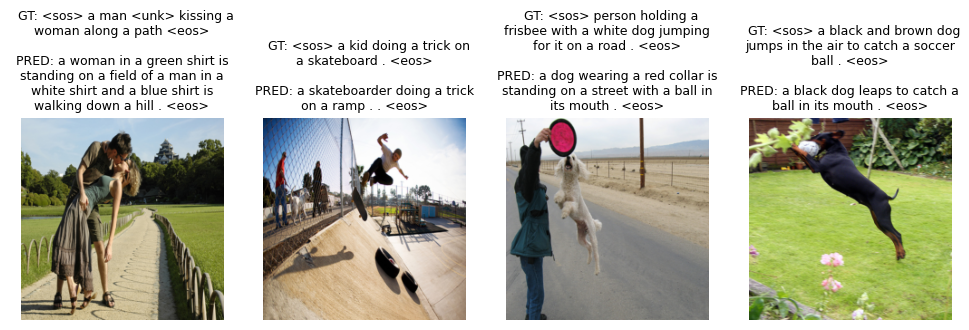

In [18]:
def predict_on_dataset(model: ImageCaptioningModel, ds, wanted_images):
    f, axs = plt.subplots(1, wanted_images)
    f.set_figwidth(3 * wanted_images)
    model.train(mode=False)
    sample_ids = random.sample(list(range(len(ds))), k=wanted_images)

    with torch.no_grad():
        for i, sample_id in enumerate(sample_ids):
            image_tensor, gt_caption, _ = ds[sample_id]

            images = image_tensor.unsqueeze(0)
            gt_captions = gt_caption.unsqueeze(0)

            preds, captions, _ = model.forward(
                images.to(device),  # gt_captions.to(device)
            )

            pred_caption = decode_caption(captions[0], VOCAB)
            pred_caption = pred_caption.replace(PAD, "")

            image = denormalize(image_tensor).numpy()
            image = np.transpose(image, (1, 2, 0))
            image[image > 1] = 1

            text_gt = "  GT: " + decode_caption(gt_caption, ds.vocab)
            wrapped_text_gt = "\n".join(wrap(text_gt, width=35))

            text_pred = "PRED: " + pred_caption
            wrapped_text_pred = "\n".join(wrap(text_pred, width=35))

            title = wrapped_text_gt + "\n\n" + wrapped_text_pred

            axs[i].imshow(image)
            axs[i].axis("off")
            axs[i].set_title(title, fontsize=9)


# predict_on_dataset(model, train_dataset, wanted_images=4)
predict_on_dataset(model, test_dataset, wanted_images=4)

### 2.4. Load an existing Image Captioning model

Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.


In [12]:
# ADD YOUR CODE HERE

### 2.5 Evaluate the chosen pre-trained captioning model on the test set

Use the same metrics chosen on step **2.3**.


In [13]:
# ADD YOUR CODE HERE

# 3. COMPARISON

Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?


In [14]:
# ADD YOUR CODE HERE